In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
import numpy as np
import os, shutil
import pandas, csv, json
import random
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style({u'font.sans-serif':['simhei']})
sns.set(font='simhei', font_scale=2) 
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd

from constants import * 
from utils import *

In [2]:
class PMExtDataset(Dataset):
    def __init__(self, config, sitename, use_ext, isTrain=False):
        
        def _read_file(mode):
            if mode == 0:
                read_path = os.path.join(config.norm_train_dir, f"{sitename}.npy") if isTrain else os.path.join(config.norm_valid_dir, f"{sitename}.npy")
            elif mode == 1:
                read_path = os.path.join(config.thres_train_dir, f"{sitename}.npy") if isTrain else os.path.join(config.thres_valid_dir, f"{sitename}.npy")
            if os.path.exists(read_path):
                data = np.load(read_path)
            else:
                raise ValueError(f"path {filename} doesn't exist")
            return data
        
        data       = _read_file(mode=0)
        thres_data = _read_file(mode=1)
        
        self.model        = config.model
        self.memory_size  = config.memory_size
        self.window_size  = config.window_size
        self.source_size  = config.source_size
        self.target_size  = config.target_size
        self.threshold    = config.threshold
        self.shuffle      = config.shuffle
        self.is_transform = config.is_transform

        data_list  = []
        thres_list = []
        x_len = self.source_size
        y_len = self.target_size
        for i in range(0, data.shape[0]-(x_len+y_len)):
            st = i
            ed = i + x_len + y_len
            window = data[st:ed]
            thres_window = thres_data[st:ed]
            y_data = window[x_len:, 7]
            # if ext in y_data, put it to ext_list, or to norm_list
            if use_ext and np.sum(y_data[y_data>=1]) > 0:
                data_list.append(window)
                thres_list.append(thres_window)
            else:
                data_list.append(window)
                thres_list.append(thres_window)
        self.data       = np.array(data_list)
        self.thres_data = np.array(thres_list)
        self.size       = self.data.shape[0]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        """
        """
        window = self.data[idx]
        x = window[:self.source_size]
        y = window[self.source_size:, 7:8]
        y_ext = y >= 1
        thres_window = self.thres_data[idx]
        thres_y = thres_window[self.source_size:]

        return  torch.FloatTensor(x),\
                torch.FloatTensor(y),\
                torch.FloatTensor(y_ext),\
                torch.FloatTensor(thres_y)


In [3]:
class PMDataset(Dataset):
    def __init__(self, config, sitename, isTrain=False):
        
        def _read_file(mode):
            if mode == 0:
                read_path = os.path.join(config.norm_train_dir, f"{sitename}.npy") if isTrain else os.path.join(config.norm_valid_dir, f"{sitename}.npy")
            elif mode == 1:
                read_path = os.path.join(config.thres_train_dir, f"{sitename}.npy") if isTrain else os.path.join(config.thres_valid_dir, f"{sitename}.npy")
            if os.path.exists(read_path):
                data = np.load(read_path)
            else:
                raise ValueError(f"path {filename} doesn't exist")
            return data
        
        self.data       = _read_file(mode=0)
        self.thres_data = _read_file(mode=1)
        
        self.model        = config.model
        self.memory_size  = config.memory_size
        self.window_size  = config.window_size
        self.source_size  = config.source_size
        self.target_size  = config.target_size
        self.threshold    = config.threshold
        self.shuffle      = config.shuffle
        self.is_transform = config.is_transform
        self.size       = self.data.shape[0] - self.source_size - self.target_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        """
        """
        st = idx
        ed = idx + self.source_size
        x = self.data[st:ed]
        
        st = idx + self.source_size
        ed = idx + self.source_size + self.target_size
        y = self.data[st:ed, 7:8]
        y_ext = y >= 1
        thres_y = self.thres_data[st:ed]

        return  torch.FloatTensor(x),\
                torch.FloatTensor(y),\
                torch.FloatTensor(y_ext),\
                torch.FloatTensor(thres_y)

In [4]:
class DNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, source_size):
        super().__init__()
        self.dense_emb = nn.Linear(input_dim, emb_dim)
        self.dense_hid = nn.Linear(emb_dim, hid_dim)
        self.dense_out = nn.Linear(hid_dim*source_size, output_dim)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU(True)
        self.leakyrelu = nn.LeakyReLU(True)
    
    def forward(self, x):
        source_size = x.shape[1]
        x = self.leakyrelu(self.dense_emb(x))
        x = self.leakyrelu(self.dense_hid(self.dropout(x)))
        x = x.view(-1, x.shape[1] * x.shape[2])
        x = self.relu(self.dense_out(self.dropout(x)))
        return x

In [5]:
class DNN_merged(nn.Module):
    def __init__(self, ext_model, nor_model, output_dim):
        super().__init__()
        self.ext_model = ext_model
        self.nor_model = nor_model
        self.dense_out = nn.Linear(output_dim * 2, output_dim)
        self.relu = nn.ReLU(True)
    
    def forward(self, x):
        source_size = x.shape[1]
        ext = self.ext_model(x)
        nor = self.nor_model(x)
        total = torch.cat((ext, nor), dim=-1)
        out = self.dense_out(total)
        return out

In [6]:
def train(model, dataloader, criterion):
    model.train()
    mean_ext_loss = 0
    mean_pred_loss = 0
    mean_rmse_loss = 0
    trange = tqdm(train_dataloader)
    for idx, data in enumerate(trange):
        # get data
        x, y_true, ext_true, thres_y = map(lambda z: z.to(device), data)
        y_true = y_true[:, -1]
        thres_y = thres_y[:, -1]
        # get loss & update
        y_pred = model(x)
        # Calculate loss
#             ext_loss  = bce(ext_pred, ext_true)
        pred_loss = criterion(y_pred, y_true)
        mse_loss  = criterion(y_pred * thres_y, y_true * thres_y)
        loss = pred_loss
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Record loss
#             mean_ext_loss  += ext_loss.item()
        mean_pred_loss += pred_loss.item()
        mean_rmse_loss += (torch.sqrt(mse_loss)).item()
        trange.set_description(\
            f"Training mean rmse: {mean_rmse_loss / (idx+1):.3e}, pred: {mean_pred_loss / (idx+1):.3e}")
    train_loss = mean_rmse_loss / len(train_dataloader)
    return train_loss

In [7]:
def test(model, dataloader, criterion):
    # Validation
    model.eval()
    mean_ext_loss = 0
    mean_pred_loss = 0
    mean_rmse_loss = 0
    trange = tqdm(dataloader)
    for idx, data in enumerate(trange):
        # get data
        x, y_true, ext_true, thres_y = map(lambda z: z.to(device), data)
        y_true = y_true[:, -1]
        thres_y = thres_y[:, -1]
        # get loss & update
        y_pred = model(x)
        # Calculate loss
        mse_loss  = criterion(y_pred * thres_y, y_true * thres_y)
        # Record loss
        mean_rmse_loss += (torch.sqrt(mse_loss)).item()
        trange.set_description(f"Validation mean rmse: {mean_rmse_loss / (idx+1):.3e}")
    valid_loss = mean_rmse_loss / len(valid_dataloader)
    return valid_loss

In [8]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = ["--no=41"]
opt = parse(args)
same_seeds(opt.seed)
save_config(opt, opt.config_dir, str(opt.no))

if opt.no is not None:
    no = opt.no
else:
    print("n is not a number")
    exit()

cpt_dir = get_path(opt.cpt_dir, mode=0)
cpt_dir = get_path(cpt_dir, no)
log_dir = get_path(opt.log_dir, mode=0)
log_file = os.path.join(log_dir, f"{no}.csv")
if os.path.exists(log_file):
    os.remove(log_file)
    with open(log_file, "w", newline='') as fp:
        writer = csv.DictWriter(fp, fieldnames=field)
        writer.writeheader()

train_ext_records = {}
for sitename in sitenames:
    if opt.skip_site and sitename not in sample_sites:
        continue
    print(sitename)
    
    # train extreme event data
    train_dataset = PMExtDataset(sitename=sitename, config=opt, use_ext=True, isTrain=True)
    valid_dataset = PMExtDataset(sitename=sitename, config=opt, use_ext=True, isTrain=False)
    train_dataloader = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=opt.batch_size, shuffle=False)
    
    ext_model = DNN(
        input_dim=opt.input_dim, 
        emb_dim=opt.emb_dim, 
        hid_dim=opt.hid_dim, 
        output_dim=opt.output_dim,
        source_size=opt.source_size
    ).to(device)
    optimizer = optim.Adam(ext_model.parameters(), lr=opt.lr)
    mse = nn.MSELoss()
    bce = nn.BCEWithLogitsLoss()

    total_epoch = opt.total_epoch
    patience = opt.patience
    best_rmse = 1e9
    earlystop_counter = 0
    st_time = datetime.now()
    
    for epoch in range(total_epoch):
        train_loss = train(ext_model, train_dataloader, mse)
        valid_loss = test(ext_model, valid_dataloader, mse)
        if best_rmse > valid_loss:
            best_rmse = valid_loss
            torch.save(ext_model.state_dict(), f"checkpoint.pt")
            earlystop_counter = 0
#             print(f">> Model saved epoch: {epoch}!!")

        # if best_loss doesn't improve for patience times, terminate training
        else:
            earlystop_counter += 1
            if earlystop_counter >= patience:
                print("Early stop!!!")
                print(f"sitename: {sitename}\nepoch: {epoch}\nbest_rmse: {best_rmse: .4f}")
                os.rename("checkpoint.pt", os.path.join(cpt_dir, f"{sitename}_extreme.pt"))
                train_ext_records[sitename] = {
                    "mode": "extreme",
                    "best_rmse": f"{best_rmse:.3f}", 
                    "epoch": epoch, 
                    "timestamp": datetime.now() - st_time
                }
                break
                
print(train_ext_records)

陽明


Validation mean rmse: 8.836e+00: 100%|██████████| 9/9 [00:00<00:00, 30.50it/s]


Early stop!!!
sitename: 陽明
epoch: 13
best_rmse:  8.6489
萬里


Validation mean rmse: 7.735e+00: 100%|██████████| 9/9 [00:00<00:00, 30.99it/s]


Early stop!!!
sitename: 萬里
epoch: 18
best_rmse:  7.7154
淡水


Validation mean rmse: 9.241e+00: 100%|██████████| 9/9 [00:00<00:00, 28.08it/s]


Early stop!!!
sitename: 淡水
epoch: 16
best_rmse:  9.1363
基隆


Validation mean rmse: 7.531e+00: 100%|██████████| 9/9 [00:00<00:00, 31.08it/s]


Early stop!!!
sitename: 基隆
epoch: 9
best_rmse:  7.4576
士林


Validation mean rmse: 1.095e+01: 100%|██████████| 9/9 [00:00<00:00, 27.92it/s]


Early stop!!!
sitename: 士林
epoch: 16
best_rmse:  10.7020
林口


Validation mean rmse: 1.056e+01: 100%|██████████| 9/9 [00:00<00:00, 28.06it/s]


Early stop!!!
sitename: 林口
epoch: 13
best_rmse:  10.0344
三重


Validation mean rmse: 5.874e+00: 100%|██████████| 9/9 [00:00<00:00, 30.03it/s]


Early stop!!!
sitename: 三重
epoch: 15
best_rmse:  5.7078
中山


Validation mean rmse: 1.030e+01: 100%|██████████| 9/9 [00:00<00:00, 30.42it/s]


Early stop!!!
sitename: 中山
epoch: 15
best_rmse:  10.0848
菜寮


Validation mean rmse: 1.085e+01: 100%|██████████| 9/9 [00:00<00:00, 30.60it/s]


Early stop!!!
sitename: 菜寮
epoch: 7
best_rmse:  10.2923
大園


Validation mean rmse: 8.839e+00: 100%|██████████| 9/9 [00:00<00:00, 28.11it/s]


Early stop!!!
sitename: 大園
epoch: 14
best_rmse:  8.7511
汐止


Validation mean rmse: 8.164e+00: 100%|██████████| 9/9 [00:00<00:00, 30.85it/s]


Early stop!!!
sitename: 汐止
epoch: 17
best_rmse:  7.9942
大同


Validation mean rmse: 1.095e+01: 100%|██████████| 9/9 [00:00<00:00, 31.13it/s]


Early stop!!!
sitename: 大同
epoch: 11
best_rmse:  10.9255
松山


Validation mean rmse: 1.083e+01: 100%|██████████| 9/9 [00:00<00:00, 30.90it/s]


Early stop!!!
sitename: 松山
epoch: 13
best_rmse:  10.6124
萬華


Validation mean rmse: 7.764e+00: 100%|██████████| 9/9 [00:00<00:00, 30.95it/s]


Early stop!!!
sitename: 萬華
epoch: 7
best_rmse:  7.7445
觀音


Validation mean rmse: 7.108e+00: 100%|██████████| 9/9 [00:00<00:00, 27.54it/s]


Early stop!!!
sitename: 觀音
epoch: 29
best_rmse:  6.9609
新莊


Validation mean rmse: 7.286e+00: 100%|██████████| 9/9 [00:00<00:00, 30.41it/s]


Early stop!!!
sitename: 新莊
epoch: 7
best_rmse:  6.8496
古亭


Validation mean rmse: 8.609e+00: 100%|██████████| 9/9 [00:00<00:00, 27.42it/s]


Early stop!!!
sitename: 古亭
epoch: 10
best_rmse:  8.4622
永和


Validation mean rmse: 7.263e+00: 100%|██████████| 9/9 [00:00<00:00, 27.17it/s]


Early stop!!!
sitename: 永和
epoch: 13
best_rmse:  7.2322
板橋


Validation mean rmse: 9.774e+00: 100%|██████████| 9/9 [00:00<00:00, 27.28it/s]


Early stop!!!
sitename: 板橋
epoch: 5
best_rmse:  9.4092
桃園


Validation mean rmse: 9.244e+00: 100%|██████████| 9/9 [00:00<00:00, 27.52it/s]


Early stop!!!
sitename: 桃園
epoch: 14
best_rmse:  8.9488
土城


Validation mean rmse: 8.669e+00: 100%|██████████| 9/9 [00:00<00:00, 27.59it/s]


Early stop!!!
sitename: 土城
epoch: 20
best_rmse:  8.6482
新店


Validation mean rmse: 1.070e+01: 100%|██████████| 9/9 [00:00<00:00, 28.00it/s]


Early stop!!!
sitename: 新店
epoch: 11
best_rmse:  10.6323
平鎮


Validation mean rmse: 4.989e+00: 100%|██████████| 9/9 [00:00<00:00, 30.84it/s]


Early stop!!!
sitename: 平鎮
epoch: 16
best_rmse:  4.8400
中壢


Validation mean rmse: 9.301e+00: 100%|██████████| 9/9 [00:00<00:00, 30.16it/s]


Early stop!!!
sitename: 中壢
epoch: 26
best_rmse:  9.0324
湖口


Validation mean rmse: 1.047e+01: 100%|██████████| 9/9 [00:00<00:00, 30.80it/s]


Early stop!!!
sitename: 湖口
epoch: 20
best_rmse:  9.9221
龍潭


Validation mean rmse: 1.112e+01: 100%|██████████| 9/9 [00:00<00:00, 30.42it/s]


Early stop!!!
sitename: 龍潭
epoch: 15
best_rmse:  10.6507
新竹


Validation mean rmse: 1.073e+01: 100%|██████████| 9/9 [00:00<00:00, 30.37it/s]


Early stop!!!
sitename: 新竹
epoch: 13
best_rmse:  9.7220
竹東


Validation mean rmse: 9.663e+00: 100%|██████████| 9/9 [00:00<00:00, 30.23it/s]


Early stop!!!
sitename: 竹東
epoch: 11
best_rmse:  9.4805
宜蘭


Validation mean rmse: 1.048e+01: 100%|██████████| 9/9 [00:00<00:00, 30.23it/s]


Early stop!!!
sitename: 宜蘭
epoch: 8
best_rmse:  10.3323
頭份


Validation mean rmse: 9.485e+00: 100%|██████████| 9/9 [00:00<00:00, 31.12it/s]


Early stop!!!
sitename: 頭份
epoch: 13
best_rmse:  9.3079
冬山


Validation mean rmse: 1.053e+01: 100%|██████████| 9/9 [00:00<00:00, 30.39it/s]


Early stop!!!
sitename: 冬山
epoch: 6
best_rmse:  10.4202
苗栗


Validation mean rmse: 4.306e+00: 100%|██████████| 9/9 [00:00<00:00, 30.94it/s]


Early stop!!!
sitename: 苗栗
epoch: 10
best_rmse:  4.0685
三義


Validation mean rmse: 1.126e+01: 100%|██████████| 9/9 [00:00<00:00, 27.78it/s]


Early stop!!!
sitename: 三義
epoch: 12
best_rmse:  11.2333
豐原


Validation mean rmse: 8.087e+00: 100%|██████████| 9/9 [00:00<00:00, 30.90it/s]


Early stop!!!
sitename: 豐原
epoch: 9
best_rmse:  7.5719
沙鹿


Validation mean rmse: 1.158e+01: 100%|██████████| 9/9 [00:00<00:00, 30.49it/s]


Early stop!!!
sitename: 沙鹿
epoch: 14
best_rmse:  11.4562
西屯


Validation mean rmse: 1.026e+01: 100%|██████████| 9/9 [00:00<00:00, 27.46it/s]


Early stop!!!
sitename: 西屯
epoch: 22
best_rmse:  10.0331
忠明


Validation mean rmse: 7.531e+00: 100%|██████████| 9/9 [00:00<00:00, 30.05it/s]


Early stop!!!
sitename: 忠明
epoch: 15
best_rmse:  7.3693
線西


Validation mean rmse: 7.376e+00: 100%|██████████| 9/9 [00:00<00:00, 28.07it/s]


Early stop!!!
sitename: 線西
epoch: 12
best_rmse:  7.2414
大里


Validation mean rmse: 1.103e+01: 100%|██████████| 9/9 [00:00<00:00, 28.14it/s]


Early stop!!!
sitename: 大里
epoch: 11
best_rmse:  10.6574
彰化


Validation mean rmse: 7.491e+00: 100%|██████████| 9/9 [00:00<00:00, 30.87it/s]


Early stop!!!
sitename: 彰化
epoch: 16
best_rmse:  7.3409
花蓮


Validation mean rmse: 7.564e+00: 100%|██████████| 9/9 [00:00<00:00, 27.90it/s]


Early stop!!!
sitename: 花蓮
epoch: 17
best_rmse:  7.4836
埔里


Validation mean rmse: 8.387e+00: 100%|██████████| 9/9 [00:00<00:00, 30.26it/s]


Early stop!!!
sitename: 埔里
epoch: 16
best_rmse:  7.9862
二林


Validation mean rmse: 9.847e+00: 100%|██████████| 9/9 [00:00<00:00, 27.23it/s]


Early stop!!!
sitename: 二林
epoch: 15
best_rmse:  9.7592
南投


Validation mean rmse: 9.016e+00: 100%|██████████| 9/9 [00:00<00:00, 29.91it/s]


Early stop!!!
sitename: 南投
epoch: 9
best_rmse:  8.9877
麥寮


Validation mean rmse: 1.112e+01: 100%|██████████| 9/9 [00:00<00:00, 27.34it/s]


Early stop!!!
sitename: 麥寮
epoch: 9
best_rmse:  10.4633
竹山


Validation mean rmse: 1.056e+01: 100%|██████████| 9/9 [00:00<00:00, 30.27it/s]


Early stop!!!
sitename: 竹山
epoch: 16
best_rmse:  10.3139
崙背


Validation mean rmse: 8.383e+00: 100%|██████████| 9/9 [00:00<00:00, 30.85it/s]


Early stop!!!
sitename: 崙背
epoch: 22
best_rmse:  7.7796
臺西


Validation mean rmse: 8.727e+00: 100%|██████████| 9/9 [00:00<00:00, 28.00it/s]


Early stop!!!
sitename: 臺西
epoch: 8
best_rmse:  7.7380
斗六


Validation mean rmse: 9.309e+00: 100%|██████████| 9/9 [00:00<00:00, 30.91it/s]


Early stop!!!
sitename: 斗六
epoch: 10
best_rmse:  9.2306
新港


Validation mean rmse: 6.666e+00: 100%|██████████| 9/9 [00:00<00:00, 30.97it/s]


Early stop!!!
sitename: 新港
epoch: 11
best_rmse:  6.5760
嘉義


Validation mean rmse: 7.990e+00: 100%|██████████| 9/9 [00:00<00:00, 27.90it/s]


Early stop!!!
sitename: 嘉義
epoch: 18
best_rmse:  7.9778
朴子


Validation mean rmse: 9.806e+00: 100%|██████████| 9/9 [00:00<00:00, 31.09it/s]


Early stop!!!
sitename: 朴子
epoch: 15
best_rmse:  9.5091
新營


Validation mean rmse: 1.074e+01: 100%|██████████| 9/9 [00:00<00:00, 30.84it/s]


Early stop!!!
sitename: 新營
epoch: 23
best_rmse:  10.5200
善化


Validation mean rmse: 7.532e+00: 100%|██████████| 9/9 [00:00<00:00, 30.81it/s]


Early stop!!!
sitename: 善化
epoch: 17
best_rmse:  7.4337
關山


Validation mean rmse: 1.093e+01: 100%|██████████| 9/9 [00:00<00:00, 30.96it/s]


Early stop!!!
sitename: 關山
epoch: 29
best_rmse:  10.5851
安南


Validation mean rmse: 8.085e+00: 100%|██████████| 9/9 [00:00<00:00, 27.68it/s]


Early stop!!!
sitename: 安南
epoch: 23
best_rmse:  7.9721
臺南


Validation mean rmse: 9.851e+00: 100%|██████████| 9/9 [00:00<00:00, 27.18it/s]


Early stop!!!
sitename: 臺南
epoch: 28
best_rmse:  9.7662
美濃


Validation mean rmse: 4.132e+00: 100%|██████████| 9/9 [00:00<00:00, 30.02it/s]


Early stop!!!
sitename: 美濃
epoch: 14
best_rmse:  4.0715
臺東


Validation mean rmse: 1.127e+01: 100%|██████████| 9/9 [00:00<00:00, 30.01it/s]


Early stop!!!
sitename: 臺東
epoch: 15
best_rmse:  10.3788
橋頭


Validation mean rmse: 4.882e+00: 100%|██████████| 9/9 [00:00<00:00, 30.99it/s]


Early stop!!!
sitename: 橋頭
epoch: 11
best_rmse:  4.7832
楠梓


Validation mean rmse: 8.304e+00: 100%|██████████| 9/9 [00:00<00:00, 31.00it/s]


Early stop!!!
sitename: 楠梓
epoch: 9
best_rmse:  8.2928
仁武


Validation mean rmse: 6.873e+00: 100%|██████████| 9/9 [00:00<00:00, 31.04it/s]


Early stop!!!
sitename: 仁武
epoch: 18
best_rmse:  6.7351
屏東


Validation mean rmse: 7.897e+00: 100%|██████████| 9/9 [00:00<00:00, 27.96it/s]


Early stop!!!
sitename: 屏東
epoch: 9
best_rmse:  7.7638
左營


Validation mean rmse: 6.908e+00: 100%|██████████| 9/9 [00:00<00:00, 31.07it/s]


Early stop!!!
sitename: 左營
epoch: 15
best_rmse:  6.5632
前金


Validation mean rmse: 9.498e+00: 100%|██████████| 9/9 [00:00<00:00, 27.76it/s]


Early stop!!!
sitename: 前金
epoch: 24
best_rmse:  9.0154
鳳山


Validation mean rmse: 8.724e+00: 100%|██████████| 9/9 [00:00<00:00, 30.48it/s]


Early stop!!!
sitename: 鳳山
epoch: 15
best_rmse:  8.6054
前鎮


Validation mean rmse: 8.540e+00: 100%|██████████| 9/9 [00:00<00:00, 27.39it/s]


Early stop!!!
sitename: 前鎮
epoch: 11
best_rmse:  8.5303
復興


Validation mean rmse: 4.234e+00: 100%|██████████| 9/9 [00:00<00:00, 27.97it/s]


Early stop!!!
sitename: 復興
epoch: 20
best_rmse:  4.1586
小港


Validation mean rmse: 6.030e+00: 100%|██████████| 9/9 [00:00<00:00, 30.87it/s]


Early stop!!!
sitename: 小港
epoch: 18
best_rmse:  5.9825
大寮


Validation mean rmse: 7.894e+00: 100%|██████████| 9/9 [00:00<00:00, 28.09it/s]


Early stop!!!
sitename: 大寮
epoch: 16
best_rmse:  7.6903
潮州


Validation mean rmse: 1.083e+01: 100%|██████████| 9/9 [00:00<00:00, 28.14it/s]


Early stop!!!
sitename: 潮州
epoch: 11
best_rmse:  10.7266
林園


Validation mean rmse: 1.070e+01: 100%|██████████| 9/9 [00:00<00:00, 31.02it/s]


Early stop!!!
sitename: 林園
epoch: 16
best_rmse:  9.8548
恆春


Validation mean rmse: 1.026e+01: 100%|██████████| 9/9 [00:00<00:00, 27.54it/s]

Early stop!!!
sitename: 恆春
epoch: 10
best_rmse:  9.8450
{'陽明': {'mode': 'extreme', 'best_rmse': '8.649', 'epoch': 13, 'timestamp': datetime.timedelta(seconds=26, microseconds=979336)}, '萬里': {'mode': 'extreme', 'best_rmse': '7.715', 'epoch': 18, 'timestamp': datetime.timedelta(seconds=36, microseconds=131005)}, '淡水': {'mode': 'extreme', 'best_rmse': '9.136', 'epoch': 16, 'timestamp': datetime.timedelta(seconds=32, microseconds=131469)}, '基隆': {'mode': 'extreme', 'best_rmse': '7.458', 'epoch': 9, 'timestamp': datetime.timedelta(seconds=18, microseconds=881645)}, '士林': {'mode': 'extreme', 'best_rmse': '10.702', 'epoch': 16, 'timestamp': datetime.timedelta(seconds=32, microseconds=157485)}, '林口': {'mode': 'extreme', 'best_rmse': '10.034', 'epoch': 13, 'timestamp': datetime.timedelta(seconds=26, microseconds=444536)}, '三重': {'mode': 'extreme', 'best_rmse': '5.708', 'epoch': 15, 'timestamp': datetime.timedelta(seconds=30, microseconds=991480)}, '中山': {'mode': 'extreme', 'best_rmse': '10.085

In [9]:
train_nor_records = {}
for sitename in sitenames:
    if opt.skip_site == 1 and sitename not in sample_sites:
        continue
    print(sitename)
    
    # train normal event data
    train_dataset = PMExtDataset(sitename=sitename, config=opt, use_ext=False, isTrain=True)
    valid_dataset = PMExtDataset(sitename=sitename, config=opt, use_ext=False, isTrain=False)
    train_dataloader = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=opt.batch_size, shuffle=False)
    
    nor_model = DNN(
        input_dim=opt.input_dim, 
        emb_dim=opt.emb_dim, 
        hid_dim=opt.hid_dim, 
        output_dim=opt.output_dim,
        source_size=opt.source_size
    ).to(device)
    optimizer = optim.Adam(nor_model.parameters(), lr=opt.lr)

    total_epoch = opt.total_epoch
    patience = opt.patience
    best_rmse = 1e9
    earlystop_counter = 0
    st_time = datetime.now()
    
    for epoch in range(total_epoch):
        train_loss = train(nor_model, train_dataloader, mse)
        valid_loss = test(nor_model, valid_dataloader, mse)
        if best_rmse > valid_loss:
            best_rmse = valid_loss
            torch.save(nor_model.state_dict(), f"checkpoint.pt")
            earlystop_counter = 0
#             print(f">> Model saved epoch: {epoch}!!")

        # if best_loss doesn't improve for patience times, terminate training
        else:
            earlystop_counter += 1
            if earlystop_counter >= patience:
                print("Early stop!!!")
                print(f"sitename: {sitename}\nepoch: {epoch}\nbest_rmse: {best_rmse: .4f}")
                os.rename("checkpoint.pt", os.path.join(cpt_dir, f"{sitename}_normal.pt"))
                train_nor_records[sitename] = {
                    "mode": "normal",
                    "best_rmse": f"{best_rmse:.3f}", 
                    "epoch": epoch, 
                    "timestamp": datetime.now() - st_time
                }
                break
    
print(train_nor_records)

Training mean rmse: 2.159e+01, pred: 2.138e-01:   0%|          | 0/42 [00:00<?, ?it/s]

陽明


Training mean rmse: 1.932e+01, pred: 2.024e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 陽明
epoch: 5
best_rmse:  9.1681
萬里


Training mean rmse: 2.065e+01, pred: 2.013e-01:   7%|▋         | 3/42 [00:00<00:01, 25.85it/s]

Early stop!!!
sitename: 萬里
epoch: 18
best_rmse:  7.7215
淡水


Training mean rmse: 1.833e+01, pred: 1.904e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 淡水
epoch: 22
best_rmse:  9.1609
基隆


Training mean rmse: 2.676e+01, pred: 2.046e-01:   7%|▋         | 3/42 [00:00<00:01, 26.62it/s]

Early stop!!!
sitename: 基隆
epoch: 15
best_rmse:  7.4334
士林


Training mean rmse: 2.936e+01, pred: 2.141e-01:   7%|▋         | 3/42 [00:00<00:01, 26.28it/s]

Early stop!!!
sitename: 士林
epoch: 25
best_rmse:  10.6664
林口


Training mean rmse: 1.455e+01, pred: 1.939e-01:   7%|▋         | 3/42 [00:00<00:01, 26.20it/s]

Early stop!!!
sitename: 林口
epoch: 6
best_rmse:  10.3311
三重


Training mean rmse: 2.789e+01, pred: 2.026e-01:   7%|▋         | 3/42 [00:00<00:01, 26.45it/s]

Early stop!!!
sitename: 三重
epoch: 16
best_rmse:  5.7452
中山


Training mean rmse: 2.423e+01, pred: 1.552e-01:   7%|▋         | 3/42 [00:00<00:01, 26.34it/s]

Early stop!!!
sitename: 中山
epoch: 9
best_rmse:  10.2310
菜寮


Training mean rmse: 2.450e+01, pred: 1.742e-01:   7%|▋         | 3/42 [00:00<00:01, 26.26it/s]

Early stop!!!
sitename: 菜寮
epoch: 7
best_rmse:  10.3394
大園


Training mean rmse: 1.960e+01, pred: 2.318e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 大園
epoch: 15
best_rmse:  8.7045
汐止


Training mean rmse: 3.069e+01, pred: 2.424e-01:   5%|▍         | 2/42 [00:00<00:02, 18.13it/s]

Early stop!!!
sitename: 汐止
epoch: 7
best_rmse:  8.0373
大同


Training mean rmse: 2.873e+01, pred: 1.988e-01:   7%|▋         | 3/42 [00:00<00:01, 26.15it/s]

Early stop!!!
sitename: 大同
epoch: 16
best_rmse:  10.8415
松山


Training mean rmse: 2.004e+01, pred: 1.953e-01:   7%|▋         | 3/42 [00:00<00:01, 26.49it/s]

Early stop!!!
sitename: 松山
epoch: 11
best_rmse:  10.7009
萬華


Training mean rmse: 2.660e+01, pred: 2.132e-01:   7%|▋         | 3/42 [00:00<00:01, 26.40it/s]

Early stop!!!
sitename: 萬華
epoch: 12
best_rmse:  7.7127
觀音


Training mean rmse: 1.633e+01, pred: 1.776e-01:   7%|▋         | 3/42 [00:00<00:01, 26.18it/s]

Early stop!!!
sitename: 觀音
epoch: 11
best_rmse:  7.3339
新莊


Training mean rmse: 1.814e+01, pred: 1.978e-01:   7%|▋         | 3/42 [00:00<00:01, 26.25it/s]

Early stop!!!
sitename: 新莊
epoch: 5
best_rmse:  6.9507
古亭


Training mean rmse: 1.913e+01, pred: 2.259e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 古亭
epoch: 8
best_rmse:  8.4143
永和


Training mean rmse: 2.009e+01, pred: 1.981e-01:   7%|▋         | 3/42 [00:00<00:01, 26.43it/s]

Early stop!!!
sitename: 永和
epoch: 25
best_rmse:  7.2154
板橋


Training mean rmse: 2.880e+01, pred: 2.182e-01:   7%|▋         | 3/42 [00:00<00:01, 26.39it/s]

Early stop!!!
sitename: 板橋
epoch: 14
best_rmse:  8.9149
桃園


Training mean rmse: 2.458e+01, pred: 1.940e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 桃園
epoch: 21
best_rmse:  8.8784
土城


Training mean rmse: 2.781e+01, pred: 2.152e-01:   7%|▋         | 3/42 [00:00<00:01, 25.59it/s]

Early stop!!!
sitename: 土城
epoch: 17
best_rmse:  8.7210
新店


Training mean rmse: 1.498e+01, pred: 2.297e-01:   7%|▋         | 3/42 [00:00<00:01, 25.77it/s]

Early stop!!!
sitename: 新店
epoch: 14
best_rmse:  10.6414
平鎮


Training mean rmse: 2.998e+01, pred: 2.317e-01:   7%|▋         | 3/42 [00:00<00:01, 25.55it/s]

Early stop!!!
sitename: 平鎮
epoch: 17
best_rmse:  4.7905
中壢


Training mean rmse: 2.624e+01, pred: 1.775e-01:   7%|▋         | 3/42 [00:00<00:01, 25.97it/s]

Early stop!!!
sitename: 中壢
epoch: 12
best_rmse:  9.3070
湖口


Training mean rmse: 2.900e+01, pred: 1.905e-01:   7%|▋         | 3/42 [00:00<00:01, 26.24it/s]

Early stop!!!
sitename: 湖口
epoch: 15
best_rmse:  10.0607
龍潭


Training mean rmse: 2.791e+01, pred: 1.931e-01:   7%|▋         | 3/42 [00:00<00:01, 26.80it/s]

Early stop!!!
sitename: 龍潭
epoch: 14
best_rmse:  10.9318
新竹


Training mean rmse: 2.068e+01, pred: 1.876e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 新竹
epoch: 24
best_rmse:  9.6703
竹東


Training mean rmse: 2.519e+01, pred: 1.914e-01:   7%|▋         | 3/42 [00:00<00:01, 26.19it/s]

Early stop!!!
sitename: 竹東
epoch: 13
best_rmse:  9.5928
宜蘭


Training mean rmse: 2.902e+01, pred: 2.260e-01:   7%|▋         | 3/42 [00:00<00:01, 25.90it/s]

Early stop!!!
sitename: 宜蘭
epoch: 10
best_rmse:  10.0116
頭份


Training mean rmse: 2.455e+01, pred: 2.002e-01:   5%|▍         | 2/42 [00:00<00:02, 17.97it/s]

Early stop!!!
sitename: 頭份
epoch: 16
best_rmse:  9.3051
冬山


Training mean rmse: 1.064e+01, pred: 1.867e-01:   7%|▋         | 3/42 [00:00<00:01, 25.52it/s]

Early stop!!!
sitename: 冬山
epoch: 10
best_rmse:  10.8067
苗栗


Training mean rmse: 2.700e+01, pred: 1.631e-01:   7%|▋         | 3/42 [00:00<00:01, 26.47it/s]

Early stop!!!
sitename: 苗栗
epoch: 18
best_rmse:  3.9983
三義


Training mean rmse: 1.858e+01, pred: 2.031e-01:   5%|▍         | 2/42 [00:00<00:02, 18.08it/s]

Early stop!!!
sitename: 三義
epoch: 17
best_rmse:  11.0776
豐原


Training mean rmse: 2.667e+01, pred: 2.113e-01:   7%|▋         | 3/42 [00:00<00:01, 26.40it/s]

Early stop!!!
sitename: 豐原
epoch: 8
best_rmse:  7.6169
沙鹿


Training mean rmse: 2.771e+01, pred: 2.090e-01:   5%|▍         | 2/42 [00:00<00:02, 18.47it/s]

Early stop!!!
sitename: 沙鹿
epoch: 24
best_rmse:  11.1213
西屯


Training mean rmse: 1.997e+01, pred: 1.885e-01:   7%|▋         | 3/42 [00:00<00:01, 25.91it/s]

Early stop!!!
sitename: 西屯
epoch: 20
best_rmse:  9.9537
忠明


Training mean rmse: 1.978e+01, pred: 1.952e-01:   5%|▍         | 2/42 [00:00<00:02, 18.23it/s]

Early stop!!!
sitename: 忠明
epoch: 10
best_rmse:  7.4343
線西


Training mean rmse: 2.595e+01, pred: 1.865e-01:   7%|▋         | 3/42 [00:00<00:01, 26.26it/s]

Early stop!!!
sitename: 線西
epoch: 18
best_rmse:  7.2091
大里


Training mean rmse: 1.830e+01, pred: 1.983e-01:   7%|▋         | 3/42 [00:00<00:01, 26.29it/s]

Early stop!!!
sitename: 大里
epoch: 11
best_rmse:  10.6091
彰化


Training mean rmse: 2.001e+01, pred: 1.982e-01:   7%|▋         | 3/42 [00:00<00:01, 26.80it/s]

Early stop!!!
sitename: 彰化
epoch: 8
best_rmse:  7.4165
花蓮


Training mean rmse: 2.185e+01, pred: 2.205e-01:   7%|▋         | 3/42 [00:00<00:01, 26.43it/s]

Early stop!!!
sitename: 花蓮
epoch: 12
best_rmse:  7.4656
埔里


Training mean rmse: 2.707e+01, pred: 2.079e-01:   5%|▍         | 2/42 [00:00<00:02, 18.39it/s]

Early stop!!!
sitename: 埔里
epoch: 13
best_rmse:  8.1447
二林


Training mean rmse: 2.105e+01, pred: 1.978e-01:   7%|▋         | 3/42 [00:00<00:01, 26.32it/s]

Early stop!!!
sitename: 二林
epoch: 20
best_rmse:  9.7465
南投


Training mean rmse: 2.850e+01, pred: 2.047e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 南投
epoch: 5
best_rmse:  8.6944
麥寮


Training mean rmse: 2.907e+01, pred: 2.244e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 麥寮
epoch: 11
best_rmse:  10.4604
竹山


Training mean rmse: 1.786e+01, pred: 1.833e-01:   7%|▋         | 3/42 [00:00<00:01, 26.37it/s]

Early stop!!!
sitename: 竹山
epoch: 17
best_rmse:  10.1706
崙背


Training mean rmse: 1.827e+01, pred: 1.951e-01:   7%|▋         | 3/42 [00:00<00:01, 26.42it/s]

Early stop!!!
sitename: 崙背
epoch: 9
best_rmse:  8.0813
臺西


Training mean rmse: 2.266e+01, pred: 1.826e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 臺西
epoch: 22
best_rmse:  7.1070
斗六


Training mean rmse: 1.764e+01, pred: 2.095e-01:   7%|▋         | 3/42 [00:00<00:01, 25.48it/s]

Early stop!!!
sitename: 斗六
epoch: 16
best_rmse:  8.9526
新港


Training mean rmse: 2.096e+01, pred: 2.114e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 新港
epoch: 17
best_rmse:  6.4621
嘉義


Training mean rmse: 2.970e+01, pred: 2.354e-01:   7%|▋         | 3/42 [00:00<00:01, 25.73it/s]

Early stop!!!
sitename: 嘉義
epoch: 11
best_rmse:  8.0279
朴子


Training mean rmse: 2.965e+01, pred: 2.164e-01:   7%|▋         | 3/42 [00:00<00:01, 26.28it/s]

Early stop!!!
sitename: 朴子
epoch: 11
best_rmse:  9.5334
新營


Training mean rmse: 1.862e+01, pred: 1.753e-01:   7%|▋         | 3/42 [00:00<00:01, 26.33it/s]

Early stop!!!
sitename: 新營
epoch: 26
best_rmse:  10.5905
善化


Training mean rmse: 2.338e+01, pred: 1.790e-01:   7%|▋         | 3/42 [00:00<00:01, 26.40it/s]

Early stop!!!
sitename: 善化
epoch: 5
best_rmse:  7.7048
關山


Training mean rmse: 2.378e+01, pred: 2.188e-01:   7%|▋         | 3/42 [00:00<00:01, 26.35it/s]

Early stop!!!
sitename: 關山
epoch: 32
best_rmse:  10.4533
安南


Training mean rmse: 2.666e+01, pred: 2.040e-01:   7%|▋         | 3/42 [00:00<00:01, 26.50it/s]

Early stop!!!
sitename: 安南
epoch: 15
best_rmse:  7.9464
臺南


Training mean rmse: 1.049e+01, pred: 2.131e-01:   7%|▋         | 3/42 [00:00<00:01, 26.78it/s]

Early stop!!!
sitename: 臺南
epoch: 15
best_rmse:  9.8563
美濃


Training mean rmse: 2.892e+01, pred: 2.347e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 美濃
epoch: 20
best_rmse:  4.0597
臺東


Training mean rmse: 1.093e+01, pred: 1.763e-01:   7%|▋         | 3/42 [00:00<00:01, 25.85it/s]

Early stop!!!
sitename: 臺東
epoch: 11
best_rmse:  10.5443
橋頭


Training mean rmse: 2.329e+01, pred: 2.085e-01:   7%|▋         | 3/42 [00:00<00:01, 26.04it/s]

Early stop!!!
sitename: 橋頭
epoch: 12
best_rmse:  4.7212
楠梓


Training mean rmse: 1.874e+01, pred: 1.901e-01:   7%|▋         | 3/42 [00:00<00:01, 25.64it/s]

Early stop!!!
sitename: 楠梓
epoch: 21
best_rmse:  8.0758
仁武


Training mean rmse: 2.036e+01, pred: 2.172e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 仁武
epoch: 14
best_rmse:  6.7593
屏東


Training mean rmse: 1.789e+01, pred: 2.157e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 屏東
epoch: 6
best_rmse:  7.5655
左營


Training mean rmse: 2.529e+01, pred: 2.075e-01:   7%|▋         | 3/42 [00:00<00:01, 26.28it/s]

Early stop!!!
sitename: 左營
epoch: 16
best_rmse:  6.6574
前金


Training mean rmse: 2.125e+01, pred: 2.159e-01:   7%|▋         | 3/42 [00:00<00:01, 25.79it/s]

Early stop!!!
sitename: 前金
epoch: 13
best_rmse:  9.2763
鳳山


Training mean rmse: 2.210e+01, pred: 1.845e-01:   7%|▋         | 3/42 [00:00<00:01, 25.45it/s]

Early stop!!!
sitename: 鳳山
epoch: 12
best_rmse:  8.6695
前鎮


Training mean rmse: 9.753e+00, pred: 1.931e-01:   7%|▋         | 3/42 [00:00<00:01, 26.86it/s]

Early stop!!!
sitename: 前鎮
epoch: 24
best_rmse:  8.4938
復興


Training mean rmse: 1.404e+01, pred: 1.957e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 復興
epoch: 19
best_rmse:  4.1257
小港


Training mean rmse: 2.134e+01, pred: 2.132e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 小港
epoch: 20
best_rmse:  5.9218
大寮


Training mean rmse: 2.838e+01, pred: 2.144e-01:   7%|▋         | 3/42 [00:00<00:01, 26.45it/s]

Early stop!!!
sitename: 大寮
epoch: 8
best_rmse:  7.8632
潮州


Training mean rmse: 2.623e+01, pred: 1.952e-01:   7%|▋         | 3/42 [00:00<00:01, 25.96it/s]

Early stop!!!
sitename: 潮州
epoch: 10
best_rmse:  10.7610
林園


Training mean rmse: 2.083e+01, pred: 1.920e-01:   0%|          | 0/42 [00:00<?, ?it/s]

Early stop!!!
sitename: 林園
epoch: 15
best_rmse:  9.9579
恆春


Validation mean rmse: 1.051e+01: 100%|██████████| 9/9 [00:00<00:00, 30.58it/s]

Early stop!!!
sitename: 恆春
epoch: 5
best_rmse:  10.1490
{'陽明': {'mode': 'normal', 'best_rmse': '9.168', 'epoch': 5, 'timestamp': datetime.timedelta(seconds=11, microseconds=643630)}, '萬里': {'mode': 'normal', 'best_rmse': '7.722', 'epoch': 18, 'timestamp': datetime.timedelta(seconds=37, microseconds=208267)}, '淡水': {'mode': 'normal', 'best_rmse': '9.161', 'epoch': 22, 'timestamp': datetime.timedelta(seconds=43, microseconds=954472)}, '基隆': {'mode': 'normal', 'best_rmse': '7.433', 'epoch': 15, 'timestamp': datetime.timedelta(seconds=30, microseconds=535602)}, '士林': {'mode': 'normal', 'best_rmse': '10.666', 'epoch': 25, 'timestamp': datetime.timedelta(seconds=50, microseconds=182489)}, '林口': {'mode': 'normal', 'best_rmse': '10.331', 'epoch': 6, 'timestamp': datetime.timedelta(seconds=13, microseconds=539666)}, '三重': {'mode': 'normal', 'best_rmse': '5.745', 'epoch': 16, 'timestamp': datetime.timedelta(seconds=32, microseconds=822967)}, '中山': {'mode': 'normal', 'best_rmse': '10.231', 'epoch

In [10]:
def get_model(path):
    checkpoint = torch.load(path)
    model = DNN(
        input_dim=opt.input_dim, 
        emb_dim=opt.emb_dim, 
        hid_dim=opt.hid_dim, 
        output_dim=opt.output_dim,
        source_size=opt.source_size
    )
    model.load_state_dict(checkpoint)
    model.to(device)
    return model

train_all_records = {}
for sitename in sitenames:
    if opt.skip_site == 1 and sitename not in sample_sites:
        continue
    print(sitename)
    
    # train combine all 
    train_dataset = PMDataset(sitename=sitename, config=opt, isTrain=True)
    valid_dataset = PMDataset(sitename=sitename, config=opt, isTrain=False)
    train_dataloader = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=opt.batch_size, shuffle=False)
    
    ext_model = get_model(os.path.join(cpt_dir, f"{sitename}_extreme.pt"))
    nor_model = get_model(os.path.join(cpt_dir, f"{sitename}_normal.pt"))
    # MARK: - learnable model or fronzen?
    ext_model.eval()
    nor_model.eval()
    
    model = DNN_merged(
        ext_model=ext_model, 
        nor_model=nor_model,
        output_dim=opt.output_dim,
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=opt.lr)

    total_epoch = opt.total_epoch
    patience = opt.patience
    best_rmse = 1e9
    earlystop_counter = 0
    st_time = datetime.now()
    
    for epoch in range(total_epoch):
        train_loss = train(model, train_dataloader, mse)
        valid_loss = test(model, valid_dataloader, mse)
        if best_rmse > valid_loss:
            best_rmse = valid_loss
            torch.save(model.state_dict(), f"checkpoint.pt")
            earlystop_counter = 0
#             print(f">> Model saved epoch: {epoch}!!")

        # if best_loss doesn't improve for patience times, terminate training
        else:
            earlystop_counter += 1
            if earlystop_counter >= patience:
                print("Early stop!!!")
                print(f"sitename: {sitename}\nepoch: {epoch}\nbest_rmse: {best_rmse: .4f}")
                os.rename("checkpoint.pt", os.path.join(cpt_dir, f"{sitename}.pt"))
                train_all_records[sitename] = {
                    "mode": "all",
                    "best_rmse": f"{best_rmse:.3f}", 
                    "epoch": epoch, 
                    "timestamp": datetime.now() - st_time
                }
                break


print(train_all_records)

Training mean rmse: 3.833e+01, pred: 6.872e-01:   7%|▋         | 3/42 [00:00<00:01, 23.49it/s]

陽明


Training mean rmse: 2.861e+01, pred: 4.464e-01:   7%|▋         | 3/42 [00:00<00:01, 23.60it/s]

Early stop!!!
sitename: 陽明
epoch: 20
best_rmse:  8.6916
萬里


Training mean rmse: 4.957e+01, pred: 1.159e+00:   5%|▍         | 2/42 [00:00<00:02, 16.86it/s]

Early stop!!!
sitename: 萬里
epoch: 15
best_rmse:  7.6968
淡水


Training mean rmse: 1.860e+01, pred: 1.977e-01:   7%|▋         | 3/42 [00:00<00:01, 23.25it/s]

Early stop!!!
sitename: 淡水
epoch: 38
best_rmse:  11.2639
基隆


Training mean rmse: 1.757e+01, pred: 9.164e-02:   7%|▋         | 3/42 [00:00<00:02, 18.63it/s]

Early stop!!!
sitename: 基隆
epoch: 19
best_rmse:  7.4169
士林


Training mean rmse: 2.218e+01, pred: 1.288e-01:   7%|▋         | 3/42 [00:00<00:01, 23.16it/s]

Early stop!!!
sitename: 士林
epoch: 7
best_rmse:  10.5360
林口


Training mean rmse: 1.107e+01, pred: 1.149e-01:   7%|▋         | 3/42 [00:00<00:01, 23.02it/s]

Early stop!!!
sitename: 林口
epoch: 7
best_rmse:  10.3822
三重


Training mean rmse: 4.911e+01, pred: 6.477e-01:   5%|▍         | 2/42 [00:00<00:02, 16.83it/s]

Early stop!!!
sitename: 三重
epoch: 7
best_rmse:  5.7279
中山


Training mean rmse: 5.189e+01, pred: 6.777e-01:   7%|▋         | 3/42 [00:00<00:01, 23.00it/s]

Early stop!!!
sitename: 中山
epoch: 12
best_rmse:  10.1349
菜寮


Training mean rmse: 1.676e+01, pred: 8.890e-02:   7%|▋         | 3/42 [00:00<00:02, 18.77it/s]

Early stop!!!
sitename: 菜寮
epoch: 39
best_rmse:  10.2196
大園


Training mean rmse: 1.829e+01, pred: 1.999e-01:   7%|▋         | 3/42 [00:00<00:01, 23.18it/s]

Early stop!!!
sitename: 大園
epoch: 20
best_rmse:  8.5974
汐止


Training mean rmse: 1.475e+01, pred: 5.848e-02:   7%|▋         | 3/42 [00:00<00:02, 18.30it/s]

Early stop!!!
sitename: 汐止
epoch: 7
best_rmse:  8.0032
大同


Training mean rmse: 1.988e+01, pred: 9.949e-02:   7%|▋         | 3/42 [00:00<00:01, 22.81it/s]

Early stop!!!
sitename: 大同
epoch: 8
best_rmse:  10.7808
松山


Training mean rmse: 1.156e+01, pred: 6.438e-02:   7%|▋         | 3/42 [00:00<00:01, 22.97it/s]

Early stop!!!
sitename: 松山
epoch: 5
best_rmse:  10.7281
萬華


Training mean rmse: 2.804e+01, pred: 2.411e-01:   7%|▋         | 3/42 [00:00<00:01, 22.92it/s]

Early stop!!!
sitename: 萬華
epoch: 6
best_rmse:  7.7286
觀音


Training mean rmse: 2.998e+01, pred: 6.157e-01:   5%|▍         | 2/42 [00:00<00:02, 16.77it/s]

Early stop!!!
sitename: 觀音
epoch: 19
best_rmse:  6.8178
新莊


Training mean rmse: 4.047e+01, pred: 1.009e+00:   7%|▋         | 3/42 [00:00<00:02, 18.27it/s]

Early stop!!!
sitename: 新莊
epoch: 10
best_rmse:  7.0450
古亭


Training mean rmse: 1.490e+01, pred: 1.408e-01:   7%|▋         | 3/42 [00:00<00:01, 22.90it/s]

Early stop!!!
sitename: 古亭
epoch: 20
best_rmse:  9.4721
永和


Training mean rmse: 1.644e+01, pred: 1.385e-01:   5%|▍         | 2/42 [00:00<00:02, 17.16it/s]

Early stop!!!
sitename: 永和
epoch: 8
best_rmse:  7.2553
板橋


Training mean rmse: 1.982e+01, pred: 1.173e-01:   7%|▋         | 3/42 [00:00<00:01, 23.28it/s]

Early stop!!!
sitename: 板橋
epoch: 8
best_rmse:  9.2425
桃園


Training mean rmse: 3.378e+01, pred: 3.629e-01:   5%|▍         | 2/42 [00:00<00:02, 17.06it/s]

Early stop!!!
sitename: 桃園
epoch: 8
best_rmse:  9.2310
土城


Training mean rmse: 6.214e+01, pred: 1.073e+00:   5%|▍         | 2/42 [00:00<00:02, 17.14it/s]

Early stop!!!
sitename: 土城
epoch: 11
best_rmse:  10.3344
新店


Training mean rmse: 1.445e+01, pred: 2.145e-01:   5%|▍         | 2/42 [00:00<00:02, 16.62it/s]

Early stop!!!
sitename: 新店
epoch: 17
best_rmse:  10.4204
平鎮


Training mean rmse: 8.403e+01, pred: 1.811e+00:   5%|▍         | 2/42 [00:00<00:02, 16.74it/s]

Early stop!!!
sitename: 平鎮
epoch: 5
best_rmse:  4.8107
中壢


Training mean rmse: 2.451e+01, pred: 1.561e-01:   7%|▋         | 3/42 [00:00<00:02, 18.39it/s]

Early stop!!!
sitename: 中壢
epoch: 40
best_rmse:  10.8544
湖口


Training mean rmse: 1.829e+01, pred: 8.049e-02:   7%|▋         | 3/42 [00:00<00:01, 22.74it/s]

Early stop!!!
sitename: 湖口
epoch: 14
best_rmse:  10.1586
龍潭


Training mean rmse: 2.273e+01, pred: 1.419e-01:   7%|▋         | 3/42 [00:00<00:01, 22.56it/s]

Early stop!!!
sitename: 龍潭
epoch: 11
best_rmse:  10.7192
新竹


Training mean rmse: 6.266e+01, pred: 1.714e+00:   7%|▋         | 3/42 [00:00<00:01, 22.79it/s]

Early stop!!!
sitename: 新竹
epoch: 5
best_rmse:  9.9750
竹東


Training mean rmse: 4.621e+01, pred: 6.382e-01:   5%|▍         | 2/42 [00:00<00:02, 17.04it/s]

Early stop!!!
sitename: 竹東
epoch: 44
best_rmse:  10.5514
宜蘭


Training mean rmse: 1.361e+01, pred: 5.091e-02:   7%|▋         | 3/42 [00:00<00:01, 23.28it/s]

Early stop!!!
sitename: 宜蘭
epoch: 15
best_rmse:  12.2361
頭份


Training mean rmse: 2.017e+01, pred: 1.325e-01:   7%|▋         | 3/42 [00:00<00:01, 23.18it/s]

Early stop!!!
sitename: 頭份
epoch: 5
best_rmse:  9.3138
冬山


Training mean rmse: 2.123e+01, pred: 7.480e-01:   7%|▋         | 3/42 [00:00<00:01, 23.23it/s]

Early stop!!!
sitename: 冬山
epoch: 22
best_rmse:  10.3833
苗栗


Training mean rmse: 6.946e+01, pred: 1.098e+00:   5%|▍         | 2/42 [00:00<00:02, 17.35it/s]

Early stop!!!
sitename: 苗栗
epoch: 50
best_rmse:  4.1264
三義


Training mean rmse: 1.194e+01, pred: 8.345e-02:   7%|▋         | 3/42 [00:00<00:01, 23.43it/s]

Early stop!!!
sitename: 三義
epoch: 13
best_rmse:  11.1576
豐原


Training mean rmse: 4.699e+01, pred: 6.555e-01:   7%|▋         | 3/42 [00:00<00:01, 23.52it/s]

Early stop!!!
sitename: 豐原
epoch: 23
best_rmse:  7.4763
沙鹿


Training mean rmse: 4.557e+01, pred: 5.505e-01:   7%|▋         | 3/42 [00:00<00:02, 19.04it/s]

Early stop!!!
sitename: 沙鹿
epoch: 14
best_rmse:  11.3781
西屯


Training mean rmse: 5.439e+01, pred: 1.419e+00:   7%|▋         | 3/42 [00:00<00:01, 23.51it/s]

Early stop!!!
sitename: 西屯
epoch: 18
best_rmse:  10.3442
忠明


Training mean rmse: 1.658e+01, pred: 1.433e-01:   7%|▋         | 3/42 [00:00<00:01, 22.55it/s]

Early stop!!!
sitename: 忠明
epoch: 42
best_rmse:  9.4756
線西


Training mean rmse: 6.393e+01, pred: 1.112e+00:   5%|▍         | 2/42 [00:00<00:02, 16.73it/s]

Early stop!!!
sitename: 線西
epoch: 15
best_rmse:  7.2482
大里


Training mean rmse: 1.711e+01, pred: 1.743e-01:   5%|▍         | 2/42 [00:00<00:02, 16.68it/s]

Early stop!!!
sitename: 大里
epoch: 5
best_rmse:  10.9032
彰化


Training mean rmse: 1.363e+01, pred: 9.084e-02:   7%|▋         | 3/42 [00:00<00:01, 22.66it/s]

Early stop!!!
sitename: 彰化
epoch: 8
best_rmse:  7.3639
花蓮


Training mean rmse: 2.431e+01, pred: 2.732e-01:   7%|▋         | 3/42 [00:00<00:02, 18.34it/s]

Early stop!!!
sitename: 花蓮
epoch: 7
best_rmse:  7.5557
埔里


Training mean rmse: 2.696e+01, pred: 2.000e-01:   7%|▋         | 3/42 [00:00<00:01, 22.73it/s]

Early stop!!!
sitename: 埔里
epoch: 6
best_rmse:  8.2551
二林


Training mean rmse: 3.243e+01, pred: 4.810e-01:   7%|▋         | 3/42 [00:00<00:01, 23.29it/s]

Early stop!!!
sitename: 二林
epoch: 11
best_rmse:  9.7729
南投


Training mean rmse: 2.753e+01, pred: 1.939e-01:   7%|▋         | 3/42 [00:00<00:01, 23.50it/s]

Early stop!!!
sitename: 南投
epoch: 5
best_rmse:  9.0238
麥寮


Training mean rmse: 2.915e+01, pred: 2.644e-01:   7%|▋         | 3/42 [00:00<00:01, 23.22it/s]

Early stop!!!
sitename: 麥寮
epoch: 12
best_rmse:  10.5239
竹山


Training mean rmse: 1.291e+01, pred: 9.716e-02:   7%|▋         | 3/42 [00:00<00:01, 22.77it/s]

Early stop!!!
sitename: 竹山
epoch: 35
best_rmse:  10.1551
崙背


Training mean rmse: 1.323e+01, pred: 1.036e-01:   7%|▋         | 3/42 [00:00<00:02, 18.67it/s]

Early stop!!!
sitename: 崙背
epoch: 8
best_rmse:  7.7573
臺西


Training mean rmse: 2.531e+01, pred: 2.349e-01:   7%|▋         | 3/42 [00:00<00:01, 22.91it/s]

Early stop!!!
sitename: 臺西
epoch: 12
best_rmse:  7.2178
斗六


Training mean rmse: 1.025e+01, pred: 6.771e-02:   7%|▋         | 3/42 [00:00<00:01, 22.94it/s]

Early stop!!!
sitename: 斗六
epoch: 12
best_rmse:  9.0748
新港


Training mean rmse: 1.654e+01, pred: 1.348e-01:   7%|▋         | 3/42 [00:00<00:01, 23.29it/s]

Early stop!!!
sitename: 新港
epoch: 7
best_rmse:  6.6075
嘉義


Training mean rmse: 3.431e+01, pred: 3.086e-01:   7%|▋         | 3/42 [00:00<00:01, 23.35it/s]

Early stop!!!
sitename: 嘉義
epoch: 11
best_rmse:  8.0790
朴子


Training mean rmse: 4.269e+01, pred: 4.418e-01:   7%|▋         | 3/42 [00:00<00:01, 22.90it/s]

Early stop!!!
sitename: 朴子
epoch: 22
best_rmse:  9.5993
新營


Training mean rmse: 1.944e+01, pred: 1.876e-01:   7%|▋         | 3/42 [00:00<00:02, 18.87it/s]

Early stop!!!
sitename: 新營
epoch: 13
best_rmse:  10.6710
善化


Training mean rmse: 1.383e+01, pred: 6.259e-02:   7%|▋         | 3/42 [00:00<00:01, 23.34it/s]

Early stop!!!
sitename: 善化
epoch: 32
best_rmse:  7.5704
關山


Training mean rmse: 3.706e+01, pred: 5.792e-01:   7%|▋         | 3/42 [00:00<00:01, 23.35it/s]

Early stop!!!
sitename: 關山
epoch: 10
best_rmse:  10.6473
安南


Training mean rmse: 5.627e+01, pred: 9.228e-01:   7%|▋         | 3/42 [00:00<00:01, 23.11it/s]

Early stop!!!
sitename: 安南
epoch: 11
best_rmse:  8.0236
臺南


Training mean rmse: 8.997e+00, pred: 1.596e-01:   7%|▋         | 3/42 [00:00<00:01, 23.33it/s]

Early stop!!!
sitename: 臺南
epoch: 16
best_rmse:  9.7138
美濃


Training mean rmse: 5.512e+01, pred: 8.913e-01:   5%|▍         | 2/42 [00:00<00:02, 16.85it/s]

Early stop!!!
sitename: 美濃
epoch: 10
best_rmse:  4.0896
臺東


Training mean rmse: 1.608e+01, pred: 3.885e-01:   7%|▋         | 3/42 [00:00<00:01, 23.02it/s]

Early stop!!!
sitename: 臺東
epoch: 6
best_rmse:  10.0075
橋頭


Training mean rmse: 1.099e+01, pred: 4.749e-02:   5%|▍         | 2/42 [00:00<00:02, 16.90it/s]

Early stop!!!
sitename: 橋頭
epoch: 10
best_rmse:  4.7921
楠梓


Training mean rmse: 4.563e+01, pred: 1.160e+00:   7%|▋         | 3/42 [00:00<00:01, 22.98it/s]

Early stop!!!
sitename: 楠梓
epoch: 9
best_rmse:  8.0410
仁武


Training mean rmse: 2.025e+01, pred: 2.222e-01:   7%|▋         | 3/42 [00:00<00:01, 23.00it/s]

Early stop!!!
sitename: 仁武
epoch: 10
best_rmse:  6.7856
屏東


Training mean rmse: 2.233e+01, pred: 3.443e-01:   5%|▍         | 2/42 [00:00<00:02, 16.65it/s]

Early stop!!!
sitename: 屏東
epoch: 20
best_rmse:  7.7386
左營


Training mean rmse: 1.582e+01, pred: 8.254e-02:   5%|▍         | 2/42 [00:00<00:02, 16.69it/s]

Early stop!!!
sitename: 左營
epoch: 5
best_rmse:  6.1480
前金


Training mean rmse: 1.419e+01, pred: 9.517e-02:   7%|▋         | 3/42 [00:00<00:01, 22.83it/s]

Early stop!!!
sitename: 前金
epoch: 12
best_rmse:  8.8912
鳳山


Training mean rmse: 3.227e+01, pred: 4.010e-01:   7%|▋         | 3/42 [00:00<00:01, 23.33it/s]

Early stop!!!
sitename: 鳳山
epoch: 7
best_rmse:  8.6296
前鎮


Training mean rmse: 5.849e+00, pred: 7.067e-02:   7%|▋         | 3/42 [00:00<00:01, 23.23it/s]

Early stop!!!
sitename: 前鎮
epoch: 15
best_rmse:  10.6414
復興


Training mean rmse: 1.478e+01, pred: 2.194e-01:   7%|▋         | 3/42 [00:00<00:02, 18.53it/s]

Early stop!!!
sitename: 復興
epoch: 9
best_rmse:  4.1514
小港


Training mean rmse: 1.069e+01, pred: 5.117e-02:   7%|▋         | 3/42 [00:00<00:01, 23.81it/s]

Early stop!!!
sitename: 小港
epoch: 8
best_rmse:  5.8432
大寮


Training mean rmse: 1.367e+01, pred: 5.426e-02:   7%|▋         | 3/42 [00:00<00:01, 23.65it/s]

Early stop!!!
sitename: 大寮
epoch: 5
best_rmse:  7.8438
潮州


Training mean rmse: 1.567e+01, pred: 7.224e-02:   7%|▋         | 3/42 [00:00<00:01, 23.76it/s]

Early stop!!!
sitename: 潮州
epoch: 9
best_rmse:  10.7205
林園


Training mean rmse: 5.809e+01, pred: 1.475e+00:   7%|▋         | 3/42 [00:00<00:01, 23.65it/s]

Early stop!!!
sitename: 林園
epoch: 12
best_rmse:  9.8867
恆春


Validation mean rmse: 1.016e+01: 100%|██████████| 9/9 [00:00<00:00, 28.20it/s]

Early stop!!!
sitename: 恆春
epoch: 39
best_rmse:  10.0988
{'陽明': {'mode': 'all', 'best_rmse': '8.692', 'epoch': 20, 'timestamp': datetime.timedelta(seconds=44, microseconds=659915)}, '萬里': {'mode': 'all', 'best_rmse': '7.697', 'epoch': 15, 'timestamp': datetime.timedelta(seconds=34, microseconds=65052)}, '淡水': {'mode': 'all', 'best_rmse': '11.264', 'epoch': 38, 'timestamp': datetime.timedelta(seconds=83, microseconds=44848)}, '基隆': {'mode': 'all', 'best_rmse': '7.417', 'epoch': 19, 'timestamp': datetime.timedelta(seconds=42, microseconds=438775)}, '士林': {'mode': 'all', 'best_rmse': '10.536', 'epoch': 7, 'timestamp': datetime.timedelta(seconds=17, microseconds=26593)}, '林口': {'mode': 'all', 'best_rmse': '10.382', 'epoch': 7, 'timestamp': datetime.timedelta(seconds=17, microseconds=290169)}, '三重': {'mode': 'all', 'best_rmse': '5.728', 'epoch': 7, 'timestamp': datetime.timedelta(seconds=17, microseconds=457906)}, '中山': {'mode': 'all', 'best_rmse': '10.135', 'epoch': 12, 'timestamp': dateti

In [11]:
# Test
save_dir = opt.test_results_dir
save_dir = get_path(save_dir, f"{no}")

name_list = []
data_list = {"f1": [], "micro": [], "macro": [], "weighted": []}
for sitename in sitenames:
    if opt.skip_site == 1 and sitename not in sample_sites:
        continue
    print(sitename)
    test_dataset    = PMDataset(sitename=sitename, config=opt, isTrain=False)
    test_dataloader = DataLoader(test_dataset, batch_size=opt.batch_size, shuffle=False)
    
    ext_model = get_model(os.path.join(cpt_dir, f"{sitename}_extreme.pt"))
    nor_model = get_model(os.path.join(cpt_dir, f"{sitename}_normal.pt"))
    # MARK: - learnable model or fronzen?
    ext_model.eval()
    nor_model.eval()
    
    model = DNN_merged(
        ext_model=ext_model, 
        nor_model=nor_model,
        output_dim=opt.output_dim,
    )
    checkpoint = torch.load(os.path.join(cpt_dir, f"{sitename}.pt"))
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    mse = nn.MSELoss()

    st_time = datetime.now()
    mean_rmse_loss = 0
    pred_list = None
    true_list = None
    value_list = None
    trange = tqdm(test_dataloader)
    for idx, data in enumerate(trange):
        # get data
        x, y_true, ext_true, thres_y = map(lambda z: z.to(device), data)
        y_true = y_true[:, -1]
        thres_y = thres_y[:, -1]
        # get loss & update
        y_pred = model(x)
        # Calculate loss
        mse_loss  = mse(y_pred * thres_y, y_true * thres_y)
        # Record loss
        mean_rmse_loss += (torch.sqrt(mse_loss)).item()
        # Recover y
        recover_y = y_pred * thres_y
        recover_y = recover_y.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_true.cpu().numpy()
        # For quantitative analysis
        y_pred[y_pred>=.5] = 1
        y_pred[y_pred<.5] = 0
        y_true[y_true>=1] = 1
        y_true[y_true<1] = 0
        # Append result
        if pred_list is None:
            pred_list = y_pred
            true_list = y_true
            value_list = recover_y
        else:
            pred_list  = np.concatenate((pred_list, y_pred), axis=0)
            true_list  = np.concatenate((true_list, y_true), axis=0)
            value_list = np.concatenate((value_list, recover_y), axis=0)
        trange.set_description(f"Test mean rmse: {mean_rmse_loss / (idx+1):.3e}")
    test_loss = mean_rmse_loss / len(test_dataloader)
    
    f1, macro, micro, weighted = get_score(true_list, pred_list)
    name_list.append(sitename)
    data_list["f1"].append(f1); data_list["macro"].append(macro)
    data_list["micro"].append(micro); data_list["weighted"].append(weighted)
#     print(f"f1: {f1}, macro: {macro}, micro: {micro}, weighted: {weighted}")
    np.save(f"{save_dir}/{sitename}.npy", value_list)

# save quantitative analysis
df = pd.DataFrame({
    "sitename": name_list,
    "f1":       data_list["f1"],
    "micro":    data_list["micro"],
    "macro":    data_list["macro"],
    "weighted": data_list["weighted"]
})
df.to_csv(f"{save_dir}/{no}.csv", index=False, encoding='utf_8_sig')

Test mean rmse: 9.883e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.12it/s]

陽明


Test mean rmse: 8.124e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.24it/s]

萬里


Test mean rmse: 1.453e+01:  22%|██▏       | 2/9 [00:00<00:00, 18.30it/s]

淡水


Test mean rmse: 7.914e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.04it/s]

基隆


Test mean rmse: 9.446e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.36it/s]

士林


Test mean rmse: 1.215e+01:  22%|██▏       | 2/9 [00:00<00:00, 18.22it/s]

林口


Test mean rmse: 5.886e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.30it/s]

三重


Test mean rmse: 1.090e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.27it/s]

中山


Test mean rmse: 1.229e+01:  22%|██▏       | 2/9 [00:00<00:00, 18.21it/s]

菜寮


Test mean rmse: 9.031e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.35it/s]

大園


Test mean rmse: 9.092e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.24it/s]

汐止


Test mean rmse: 1.159e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.16it/s]

大同


Test mean rmse: 1.155e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.00it/s]

松山


Test mean rmse: 9.197e+00:  33%|███▎      | 3/9 [00:00<00:00, 20.67it/s]

萬華


Test mean rmse: 6.648e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.35it/s]

觀音


Test mean rmse: 7.120e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.16it/s]

新莊


Test mean rmse: 1.048e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.28it/s]

古亭


Test mean rmse: 7.240e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.25it/s]

永和


Test mean rmse: 9.455e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.26it/s]

板橋


Test mean rmse: 9.024e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.36it/s]

桃園


Test mean rmse: 1.008e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.36it/s]

土城


Test mean rmse: 1.129e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.10it/s]

新店


Test mean rmse: 4.789e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.16it/s]

平鎮


Test mean rmse: 1.222e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.16it/s]

中壢


Test mean rmse: 1.168e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.20it/s]

湖口


Test mean rmse: 1.125e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.34it/s]

龍潭


Test mean rmse: 1.015e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.22it/s]

新竹


Test mean rmse: 1.275e+01:  22%|██▏       | 2/9 [00:00<00:00, 18.18it/s]

竹東


Test mean rmse: 1.308e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.26it/s]

宜蘭


Test mean rmse: 9.399e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.13it/s]

頭份


Test mean rmse: 1.033e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.30it/s]

冬山


Test mean rmse: 3.887e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.01it/s]

苗栗


Test mean rmse: 1.336e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.31it/s]

三義


Test mean rmse: 8.239e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.16it/s]

豐原


Test mean rmse: 1.184e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.09it/s]

沙鹿


Test mean rmse: 1.250e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.37it/s]

西屯


Test mean rmse: 1.008e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.18it/s]

忠明


Test mean rmse: 7.767e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.29it/s]

線西


Test mean rmse: 1.350e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.19it/s]

大里


Test mean rmse: 7.978e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.12it/s]

彰化


Test mean rmse: 8.424e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.19it/s]

花蓮


Test mean rmse: 8.283e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.34it/s]

埔里


Test mean rmse: 1.053e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.32it/s]

二林


Test mean rmse: 1.006e+01:  33%|███▎      | 3/9 [00:00<00:00, 20.61it/s]

南投


Test mean rmse: 1.116e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.12it/s]

麥寮


Test mean rmse: 1.030e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.21it/s]

竹山


Test mean rmse: 8.598e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.34it/s]

崙背


Test mean rmse: 7.536e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.43it/s]

臺西


Test mean rmse: 9.999e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.33it/s]

斗六


Test mean rmse: 6.771e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.43it/s]

新港


Test mean rmse: 8.101e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.46it/s]

嘉義


Test mean rmse: 1.078e+01:  22%|██▏       | 2/9 [00:00<00:00, 18.23it/s]

朴子


Test mean rmse: 1.100e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.32it/s]

新營


Test mean rmse: 8.895e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.37it/s]

善化


Test mean rmse: 1.062e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.28it/s]

關山


Test mean rmse: 8.223e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.22it/s]

安南


Test mean rmse: 1.162e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.14it/s]

臺南


Test mean rmse: 4.058e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.33it/s]

美濃


Test mean rmse: 1.067e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.27it/s]

臺東


Test mean rmse: 5.281e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.12it/s]

橋頭


Test mean rmse: 8.550e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.11it/s]

楠梓


Test mean rmse: 7.111e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.22it/s]

仁武


Test mean rmse: 8.514e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.22it/s]

屏東


Test mean rmse: 6.094e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.26it/s]

左營


Test mean rmse: 1.000e+01:  33%|███▎      | 3/9 [00:00<00:00, 20.46it/s]

前金


Test mean rmse: 8.906e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.20it/s]

鳳山


Test mean rmse: 1.089e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.05it/s]

前鎮


Test mean rmse: 4.148e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.25it/s]

復興


Test mean rmse: 6.293e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.17it/s]

小港


Test mean rmse: 9.096e+00:  33%|███▎      | 3/9 [00:00<00:00, 26.18it/s]

大寮


Test mean rmse: 1.129e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.13it/s]

潮州


Test mean rmse: 1.044e+01:  33%|███▎      | 3/9 [00:00<00:00, 26.17it/s]

林園


Test mean rmse: 1.154e+01:  22%|██▏       | 2/9 [00:00<00:00, 18.18it/s]

恆春


Test mean rmse: 1.010e+01: 100%|██████████| 9/9 [00:00<00:00, 25.04it/s]


sitename: 陽明
origin  mean ± std: 14.43 ± 21.74
predict mean ± std: 17.51 ± 8.60


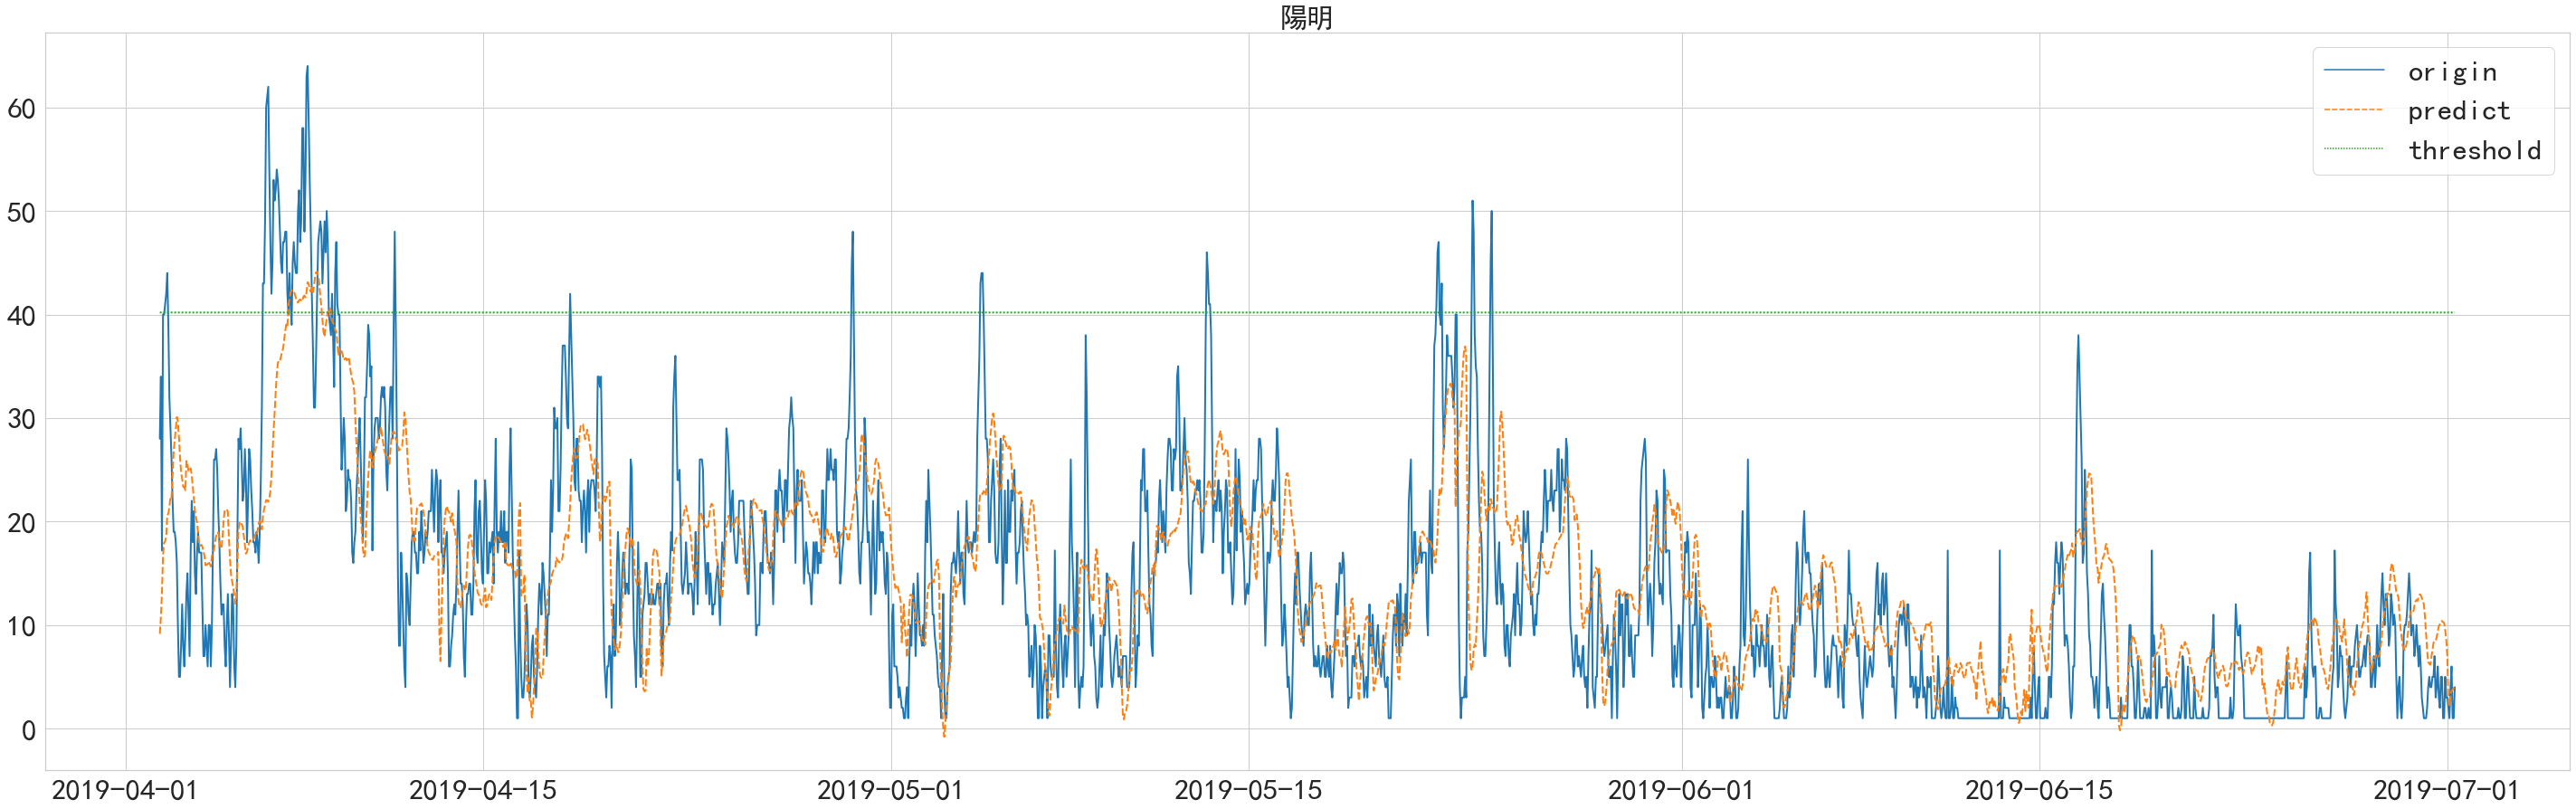

In [14]:
# Plot test results
no=41
# method="all"
method="merged"
origin_path = "data/origin/valid"
thres_path = "data/thres/valid"
result_path = os.path.join(f"split_method/test_results", f"{no}_{method}")
sitenames = ['陽明','淡水','士林','中山','萬華','觀音','古亭','永和','板橋','土城','新店']

for sitename in sitenames:
    print(f"sitename: {sitename}")
    origin_data  = np.load(f"{origin_path}/{sitename}.npy")
    thres_data   = np.load(f"{thres_path}/{sitename}.npy")
    predict_data = np.load(f"{result_path}/{sitename}.npy")

    source_size = 24
    target_size = 8
    origin_data = origin_data[source_size+target_size:]
    thres_data  = thres_data[source_size+target_size:]
#     print(origin_data.shape, predict_data.shape, thres_data.shape)
#     predict_data = np.expand_dims(predict_data, axis=-1)
    # create thres_data
#     print(origin_data[0, -3:])
    print(f"origin  mean ± std: {origin_data.mean():.2f} ± {origin_data.std():.2f}")
    print(f"predict mean ± std: {predict_data.mean():.2f} ± {predict_data.std():.2f}")
    st = 24*30*3
    ed = 24*30*6 #predict_data.shape[0]
    origin_data  = origin_data [st:ed]
    predict_data = predict_data[st:ed]
    thres_data   = thres_data[st:ed]
    mse = np.mean((np.square(predict_data - origin_data)))
    rmse = np.sqrt(mse)
#     print(f"rmse: {rmse:.3f}")
#     print(origin_data[:, 7:8].shape, predict_data[:, :1].shape)
    y = np.concatenate((origin_data[:, 7:8], predict_data[:, :1], thres_data), axis=-1)
    
    plt.figure(figsize=(50, 15))
    # TODO: the date should be customized
    st_time = f"2019-{int(origin_data[0][-3])}-{int(origin_data[0][-2])} {int(origin_data[0][-1])}:00:00"
    dates = pd.date_range(st_time, periods=predict_data.shape[0], freq="H")
    data = pd.DataFrame(y, dates, columns=["origin", "predict", "threshold"])
#     sns.set_theme()
#     sns.set(font_scale=1.5)
    sns.set(font='simhei', font_scale=3, style="whitegrid") 
    plot = sns.lineplot(data=data, palette="tab10", linewidth=2, )
    plot.set_title(f"{sitename}", fontsize=30)
    plt.show()
    break


In [ ]:

def line_plot(file_name, st, ed):
    y = np.load(file_name)[st:ed]
    print(y.shape)
    x = np.arange(len(y))

    fig, ax = plt.subplots(figsize=(20, 8))
    plt.plot(x, y)

filename = "data/thres/valid/萬里.npy"
st = 0
ed = -1

line_plot(filename, st, ed)